HOSPITALIZATION ANALYSIS

Objective: 
The objective of this report is to analyze the relationship between heart age, as predicted by ECG data, and hospitalization outcomes in patients. The analysis seeks to determine whether differences between a patient's predicted heart age and their actual age (referred to as the heart age gap) can predict the frequency of hospitalizations. The report focuses on understanding how advanced or decelerated heart age correlates with hospital admissions and mortality over a period of time.


This is the second outcome we will evaluate. It accounts for hospitalizations that did not result in death within 365 days of the first hospitalization.
The ECG from the First hospitalization will be used to calculate the heart age of the patients at the time of their first hospitalization.
We will then use this data to see the correlation of this age with the outcome.

We will do this with the following steps:
    1. Preprocessing the ECG data
    2. Importing the model
    3. Calculating the heart age for each patient
    4. Visualizing the data
    5. Calculating the heart age gap
    6. Calculating the correlation between the heart age gap and the outcome


Table of Contents:

    Introduction
        Background on heart age prediction from ECGs
        Significance of studying heart age in relation to hospitalizations

    Data Preprocessing
        Loading ECG and hospitalization data
        ECG signal preprocessing: Resampling, noise filtering, and normalization

    Heart Age Prediction Model
        ResNet1d model used for predicting heart age
        Evaluating and validating model predictions

    Heart Age Gap Calculation
        Definition of advanced, normal, and decelerated heart age
        Calculating heart age gaps for patients

    Correlation Analysis
        Scatter plot: Predicted age vs. Actual age
        Categorization of heart age gaps

    Hospitalization Data Analysis
        Merging heart age predictions with hospitalization records

    Statistical Analysis
        Poisson regression: Initial model fitting
        Negative binomial regression: Handling overdispersed data
        Results: Coefficients for advanced and decelerated heart age

    Visualization
        Histogram of hospitalization counts by heart age category
        Bar plot: Regression coefficients for heart age categories

    Conclusion
        Summary of findings on heart age and hospitalization risk
        Implications for patient care and predictive analytics

    References

In [2]:

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro
import wfdb
import scipy.signal as signal
import torch
import os
from lifelines import KaplanMeierFitter
from model_ecg.resnet import ResNet1d
import h5py
from model_ecg.resnet import ResNet1d
import tqdm
import h5py
import torch
import os
import json
import numpy as np
import argparse
from warnings import warn
import pandas as pd
import statsmodels.api as sm

# Formatting for my pandas dataframes, ignore:

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None) 


In [7]:
# Load the csv file for the hospitalization dataframe

hospitalization_analysis = pd.read_csv('C:\\Users\\Vero Ramirez\\Desktop\\CODE\\CODE\\hosp_analysis.csv')

In [7]:
# Lets load the raw data for the ECGs

def load_ecg_data(df, path):
    '''
    Load the ECG data from the specified path and add it to the DataFrame.
    
    Args:
        df: The DataFrame that will 
        path: path containing the ECG paths.
    
    Returns:
        The DataFrame with the ECG data added.
        
    '''
    data = [wfdb.rdsamp(path +f) for f in df.path]
    data = np.array([signal for signal, meta in data])
    return data

# Load the ecg data for the mortality analysis dataframe

raw_hospitalization = load_ecg_data(hospitalization_analysis, 
 'C:/Users/Vero Ramirez/Desktop/CODE/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/')
print(raw_hospitalization.shape)


(13019, 5000, 12)


In [116]:
def load_single_ecg_data(df, path):
    '''
    Load the ECG data from the specified path and add it to the DataFrame.
    
    Args:
        df: The DataFrame that will contain the path information (or a single record).
        path: Path containing the ECG files.
    
    Returns:
        The loaded ECG signal data as a NumPy array.
    '''
    # Ensure that df is iterable; if it's a single row, convert to DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame().T  # Convert Series to a DataFrame if it's a single row

    # Load the data for each path in the DataFrame
    data = [wfdb.rdsamp(path + f) for f in df['path']]
    data = np.array([signal for signal, meta in data])
    
    return data

# test sample for the filter (just one ecg)
raw_sample = load_single_ecg_data(hospitalization_analysis.iloc[[1]],
'C:/Users/Vero Ramirez/Desktop/CODE/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/')
raw_sample.shape

(1, 5000, 12)

To preprocess and clean the ecg signals, we will use the following functions:
    
    1. resample_ecg: to resample the ecg signals
    2. filter_ecg: to filter the ecg signals
    3. normalize_ecg: to normalize the ecg signals

In [9]:
# As you can see, the ECG data is noisy and contains a lot of artifacts.
# We will preprocess the data to remove the noise and artifacts.

''' 
We also need the model input to be shape = (N, 12, 4096), N being the number of samples,
12 the number of leads, and 4096 the points of the ECG tracings sampled at 400Hz .
Segmentation is NOT needed, as all the ecgs are already 10 seconds long.
'''

# Preprocess the ECG data

# 1. Downsampling 

def resample_ecg(ecg_signal, new_length=4096):
    '''
    Resample the ECG signal to the specified length.
    
   Parameters: 
            ecg_signal: The ECG signal to resample
            new_length: The new length of the ECG signal
    Returns: The resampled ECG signal 
    '''

    return signal.resample(ecg_signal, new_length, axis=1)

# 2. Noise removal

def bandpass(ecg_signal, lowcut=0.5, highcut=40, fs=500, order=10):
    '''
    Apply a bandpass FIR filter to remove noise from the ECG signal using a windowed design.
    
    Parameters:
    ecg_signal (numpy array): The noisy ECG signal.
    lowcut (float): The low frequency cut-off for the bandpass filter (in Hz).
    highcut (float): The high frequency cut-off for the bandpass filter (in Hz).
    fs (int): The sampling frequency (Hz).
    order (int): The order of the filter (number of taps).

    Returns:
    numpy array: The filtered ECG signal.
    '''
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    
     # Design FIR bandpass filter using firwin
    taps = signal.firwin(order + 1, [low, high], pass_zero=False, fs=fs)
    
    # Apply the filter with custom padlen
    filtered_signal = signal.filtfilt(taps, 1.0, ecg_signal, padlen=100, axis=1)
    
    return filtered_signal


# 3. Normalization

def normalize_ecg(ecg_signal):
    '''
    Normalize each sample independently using z-score normalization.
    
    Parameters:
    ecg_signal (numpy array): Input ECG signal (shape: samples, timepoints, leads).
    
    Returns:
    numpy array: Z-score normalized ECG signal (same shape as input).
    '''
    # Calculate mean and std for each sample across timepoints and leads (axis 1 and 2)
    mean_val = np.mean(ecg_signal, axis=(1, 2), keepdims=True)
    std_val = np.std(ecg_signal, axis=(1, 2), keepdims=True)
    
    # Prevent division by zero in case std_val is zero
    std_val[std_val == 0] = 1
    
    # Apply z-score normalization independently for each sample
    ecg_signal_norm = (ecg_signal - mean_val) / std_val
    
    return ecg_signal_norm


In [10]:
#Resample the ECG signals
resampled_hosp = resample_ecg(raw_hospitalization, new_length=4096)

# Apply bandpass filter to the reshaped ECG
filtered_hosp = bandpass(resampled_hosp, lowcut=0.1, highcut=40, fs=400)

# Apply the normalization to the filtered ECG
normalized_hosp = normalize_ecg(filtered_hosp)

In [11]:
# Change the type to float32
hosp_input = normalized_hosp.astype(np.float32)
normalized_hosp.shape

(13019, 4096, 12)

In [12]:
# Number of leads
num_leads = normalized_hosp[0].shape[1]

# Create a figure with subplots: 2 rows for each lead (raw and filtered)
plt.figure(figsize=(60, 16 * num_leads))

# Lead labels in the standard order
lead_labels = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Plot each lead separately (raw and filtered)
for i in range(num_leads):
    # Plot raw ECG lead
    plt.subplot(num_leads, 2, 2*i + 1)
    plt.plot(raw_sample[0][:, i])  # Plot the raw ECG for the i-th lead
    plt.title(f'Raw ECG Lead {lead_labels[i]}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    # Plot filtered ECG lead
    plt.subplot(num_leads, 2, 2*i + 2)
    plt.plot(normalized_hosp[0][:, i])  # Plot the filtered ECG for the i-th lead
    plt.title(f'Filtered ECG Lead {lead_labels[i]}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [13]:
# ResNet model for age prediction
'''
I did not import it from the script so I could show the code here. I modified the original by 
deleting tha parser and the arguments.

'''

def evaluate(mdl, traces, batch_size=8, output='predicted_age.csv', ids_dset=None):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Load the model checkpoint
    ckpt = torch.load(os.path.join(mdl, 'model.pth'), map_location=lambda storage, loc: storage)
    
    # Load the model configuration
    config_path = os.path.join(mdl, 'config.json')  # Avoid conflict with json module
    with open(config_path, 'r') as f:
        config_dict = json.load(f)
    
    # Create the ResNet1d model instance
    N_LEADS = 12
    model = ResNet1d(
        input_dim=(N_LEADS, config_dict['seq_length']),
        blocks_dim=list(zip(config_dict['net_filter_size'], config_dict['net_seq_lengh'])),
        n_classes=1,
        kernel_size=config_dict['kernel_size'],
        dropout_rate=config_dict['dropout_rate']
    )
    
    # Load model weights
    model.load_state_dict(ckpt["model"])
    model = model.to(device)
    
    # Use the traces directly as passed into the function
    n_total = len(traces)
    
    # Load the IDs if they exist
    if ids_dset:
        ids = ids_dset
    else:
        ids = range(n_total)
    
    # Initialize predicted ages array
    predicted_age = np.zeros((n_total,))
    
    # Set the model to evaluation mode
    model.eval()
    n_batches = int(np.ceil(n_total / batch_size))
    
    # Evaluate the model
    end = 0
    for i in tqdm.tqdm(range(n_batches)):
        start = end
        end = min((i + 1) * batch_size, n_total)
        with torch.no_grad():
            x = torch.tensor(traces[start:end, :, :]).transpose(-1, -2)
            x = x.to(device, dtype=torch.float32)
            y_pred = model(x)
        predicted_age[start:end] = y_pred.detach().cpu().numpy().flatten()
    
    # Save the predictions to a CSV file
    df = pd.DataFrame({'ids': ids, 'predicted_age': predicted_age})
    df = df.set_index('ids')
    df.to_csv(output)

path_to_model = "C:\\Users\\Vero Ramirez\\Desktop\\CODE\\CODE\\model_ecg\\"

In [14]:
# Evaluate the model
evaluate(path_to_model, hosp_input, batch_size=8, output='predicted_age_hosp.csv', ids_dset=None)

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_29856\2735156044.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(mdl, 'model.pth'), ma

In [8]:
# Finally, I will merge the predictions with the hospitalization analysis data

# Load the predicted age data 
predicted_age = pd.read_csv('C:\\Users\\Vero Ramirez\\Desktop\\CODE\\CODE\\predicted_age_hosp.csv')

# Merge the predicted age data with the mortality data
hospitalization_analysis['predicted_age'] = predicted_age['predicted_age'].values


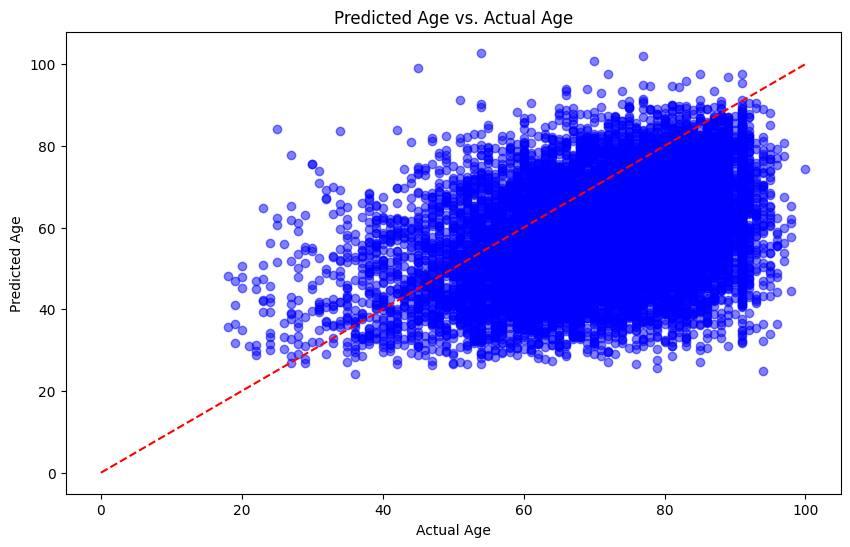

In [115]:
# Lets make a scatter plot of the predicted age vs the actual age

plt.figure(figsize=(10, 6))
plt.scatter(hospitalization_analysis['age'], hospitalization_analysis['predicted_age'], 
            color='blue', alpha=0.5)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')
plt.title('Predicted Age vs. Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

In [12]:
# lets separate the data in three groups, normal, advanced and decelerated heart age 

''' 
Advanced heart age: The heart age gap is > 8.38  (the mean standard error of the model) 
Normal heart age: The heart age gap is between -8.38 and 8.38
Decelerated heart age: The heart age gap is < -8.38
'''

hospitalization_analysis['heart_age_gap'] = hospitalization_analysis['predicted_age'] - \
    hospitalization_analysis['age']

# Create a new column to categorize the heart age gap

def categorize_heart_age_gap(row):
    if row['heart_age_gap'] > 8.38:
        return 'Advanced'
    elif row['heart_age_gap'] < -8.38:
        return 'Decelerated'
    else:
        return 'Normal'

# Apply the function to the DataFrame
hospitalization_analysis['heart_age_category'] = hospitalization_analysis.\
    apply(categorize_heart_age_gap, axis=1)

#Lets calculate the time to event for the patients that died

hospitalization_analysis['dod'] = hospitalization_analysis['dod'].astype('datetime64[ns]')
hospitalization_analysis['admittime'] = hospitalization_analysis['admittime']\
    .astype('datetime64[ns]')

hospitalization_analysis['time_to_event'] = (hospitalization_analysis['dod'] - \
    hospitalization_analysis['admittime']).dt.days

# Lets censor the patients that are still alive or that died after 365 days of their last 
# hospitalization

hospitalization_analysis['event_indicator'] = np.where(
    hospitalization_analysis['dod'].isna() | (hospitalization_analysis['time_to_event'] > 365), 
    0,  # Still alive or died after 365 days (censored)
    1   # Died within 365 days
)

# Replace all the NaN values in the 'time_to_event' column with 365
hospitalization_analysis['time_to_event'] = hospitalization_analysis['time_to_event'].fillna(400)


hospitalization_analysis.head()

subject_id   hadm_id           admittime            dischtime  \
0    10000980  29654838 2188-01-03 17:41:00  2188-01-05 17:30:00   
1    10001843  21728396 2131-11-09 16:05:00  2131-11-11 11:23:00   
2    10001877  21320596 2150-11-21 23:02:00  2150-11-23 16:46:00   
3    10002013  21975601 2159-12-14 23:55:00  2159-12-17 14:04:00   
4    10002155  23822395 2129-08-04 12:44:00  2129-08-18 16:53:00   

      admission_type      admission_location                    race gender  \
0           EW EMER.          EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
1  OBSERVATION ADMIT  TRANSFER FROM HOSPITAL                   WHITE      M   
2     EU OBSERVATION          EMERGENCY ROOM                   WHITE      M   
3           EW EMER.          EMERGENCY ROOM                   WHITE      F   
4           EW EMER.          PROCEDURE SITE                   WHITE      F   

  anchor_year_group  anchor_year  anchor_age        dod    study_id  \
0       2008 - 2010         2186          73 2193-08-26  49560547.0   
1       2017 - 2019         2131          73        NaT  43647002.0   
2       2008 - 2010         2149          89        NaT  42315368.0   
3       2008 - 2010         2156          53        NaT  48919255.0   
4       2008 - 2010         2128          80 2131-03-10  48586557.0   

    file_name             ecg_time                                      path  \
0  49560547.0  2188-01-04 16:43:00  files/p1000/p10000980/s49560547/49560547   
1  43647002.0  2131-11-10 09:04:00  files/p1000/p10001843/s43647002/43647002   
2  42315368.0  2150-11-21 23:10:00  files/p1000/p10001877/s42315368/42315368   
3  48919255.0  2159-12-17 03:19:00  files/p1000/p10002013/s48919255/48919255   
4  48586557.0  2129-08-11 08:43:00  files/p1000/p10002155/s48586557/48586557   

   length_of_stay_(days)  subject_id_y icd_code  icd_version  seq_num  \
0                      1    10000980.0     4280          9.0     10.0   
1                      1    10001843.0    I5031         10.0      2.0   
2                      1    10001877.0     4280          9.0      2.0   
3                      2    10002013.0    42832          9.0      2.0   
4                     14    10002155.0    42821          9.0      3.0   

                                   long_title  age  predicted_age  \
0       Congestive heart failure, unspecified   75      50.321297   
1  Acute diastolic (congestive) heart failure   73      57.754532   
2       Congestive heart failure, unspecified   90      67.451126   
3             Chronic diastolic heart failure   56      43.551422   
4                Acute systolic heart failure   81      64.386223   

   heart_age_gap heart_age_category  time_to_event  event_indicator  
0     -24.678703        Decelerated         2061.0                0  
1     -15.245468        Decelerated          400.0                0  
2     -22.548874        Decelerated          400.0                0  
3     -12.448578        Decelerated          400.0                0  
4     -16.613777        Decelerated          582.0                0

In [13]:
# Lets gather the number of hospitalizations for each heart age category from the admissions.csv

# Load the admissions data
admissions = pd.read_csv('C:\\Users\\Vero Ramirez\\Desktop\\CODE\\CODE\\admissions.csv')

# Rename the second column to 'subject_id'
hospitalization_analysis = hospitalization_analysis.rename(columns={'subject_id_x': 'subject_id'})

# Count the number of hospitalizations for each patient
hospitalization_count = admissions.groupby('subject_id').size() \
    .reset_index(name='hospitalization_count')

# Merge the hospitalization count with the existing hospitalization_analysis data
hospitalization_analysis_1 = pd.merge(hospitalization_analysis, 
                                      hospitalization_count[['subject_id', 'hospitalization_count']],
                                      on='subject_id', how='left')

# Display the updated DataFrame
hospitalization_analysis_1.head()


subject_id   hadm_id           admittime            dischtime  \
0    10000980  29654838 2188-01-03 17:41:00  2188-01-05 17:30:00   
1    10001843  21728396 2131-11-09 16:05:00  2131-11-11 11:23:00   
2    10001877  21320596 2150-11-21 23:02:00  2150-11-23 16:46:00   
3    10002013  21975601 2159-12-14 23:55:00  2159-12-17 14:04:00   
4    10002155  23822395 2129-08-04 12:44:00  2129-08-18 16:53:00   

      admission_type      admission_location                    race gender  \
0           EW EMER.          EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
1  OBSERVATION ADMIT  TRANSFER FROM HOSPITAL                   WHITE      M   
2     EU OBSERVATION          EMERGENCY ROOM                   WHITE      M   
3           EW EMER.          EMERGENCY ROOM                   WHITE      F   
4           EW EMER.          PROCEDURE SITE                   WHITE      F   

  anchor_year_group  anchor_year  anchor_age        dod    study_id  \
0       2008 - 2010         2186          73 2193-08-26  49560547.0   
1       2017 - 2019         2131          73        NaT  43647002.0   
2       2008 - 2010         2149          89        NaT  42315368.0   
3       2008 - 2010         2156          53        NaT  48919255.0   
4       2008 - 2010         2128          80 2131-03-10  48586557.0   

    file_name             ecg_time                                      path  \
0  49560547.0  2188-01-04 16:43:00  files/p1000/p10000980/s49560547/49560547   
1  43647002.0  2131-11-10 09:04:00  files/p1000/p10001843/s43647002/43647002   
2  42315368.0  2150-11-21 23:10:00  files/p1000/p10001877/s42315368/42315368   
3  48919255.0  2159-12-17 03:19:00  files/p1000/p10002013/s48919255/48919255   
4  48586557.0  2129-08-11 08:43:00  files/p1000/p10002155/s48586557/48586557   

   length_of_stay_(days)  subject_id_y icd_code  icd_version  seq_num  \
0                      1    10000980.0     4280          9.0     10.0   
1                      1    10001843.0    I5031         10.0      2.0   
2                      1    10001877.0     4280          9.0      2.0   
3                      2    10002013.0    42832          9.0      2.0   
4                     14    10002155.0    42821          9.0      3.0   

                                   long_title  age  predicted_age  \
0       Congestive heart failure, unspecified   75      50.321297   
1  Acute diastolic (congestive) heart failure   73      57.754532   
2       Congestive heart failure, unspecified   90      67.451126   
3             Chronic diastolic heart failure   56      43.551422   
4                Acute systolic heart failure   81      64.386223   

   heart_age_gap heart_age_category  time_to_event  event_indicator  \
0     -24.678703        Decelerated         2061.0                0   
1     -15.245468        Decelerated          400.0                0   
2     -22.548874        Decelerated          400.0                0   
3     -12.448578        Decelerated          400.0                0   
4     -16.613777        Decelerated          582.0                0   

   hospitalization_count  
0                     14  
1                      1  
2                      2  
3                     18  
4                      9

<Figure size 1200x600 with 0 Axes>

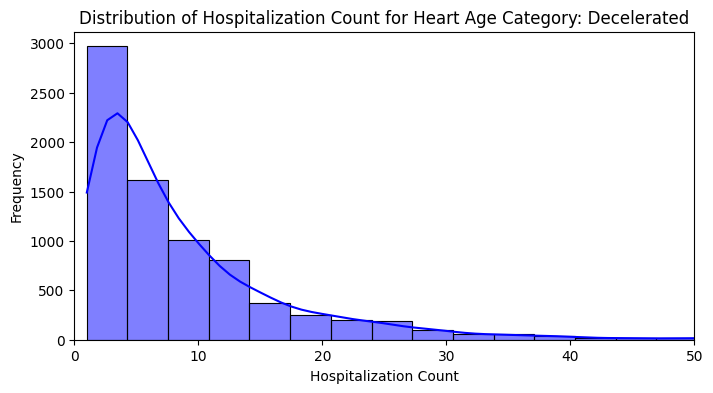

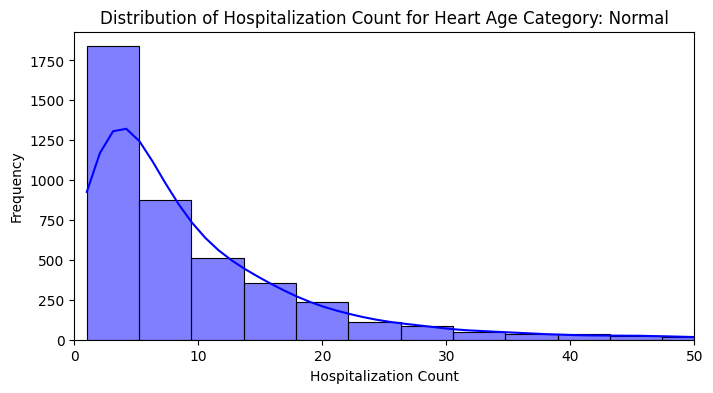

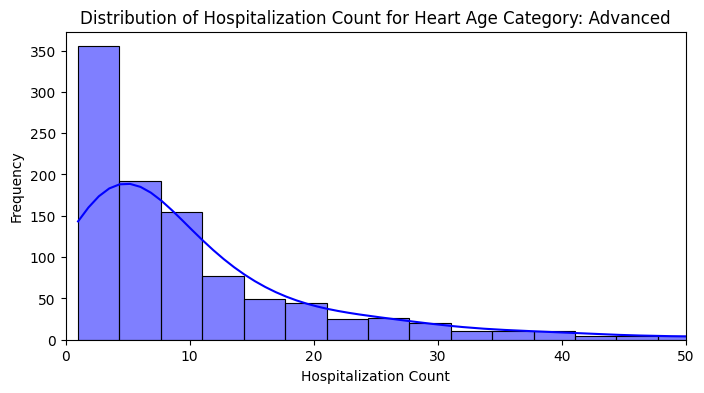

In [14]:
# Lets do a visualization of the distribution of heart age categories by hospitalization count

# Get unique heart age categories
heart_age_categories = hospitalization_analysis_1['heart_age_category'].unique()

# Create separate histograms for each heart age category
plt.figure(figsize=(12, 6))

for category in heart_age_categories:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=hospitalization_analysis_1[hospitalization_analysis_1['heart_age_category'] == category], 
                 x='hospitalization_count', bins=50, color='b', kde=True)
    plt.title(f'Distribution of Hospitalization Count for Heart Age Category: {category}')
    plt.xlabel('Hospitalization Count')
    plt.ylabel('Frequency')
    plt.xlim(0,50)
    plt.show()


In [17]:
# check the dispersion of the hospitalization count across the heart age categories
'''
Because the data has 3 categories, we will use dummy variables to represent the heart age categories.

'''

#drop patients with no heart age gap
hospitalization_analysis_1 = hospitalization_analysis_1.dropna(subset=['heart_age_gap'])

# One-hot encode heart_age_category (drop 'Normal' as the reference category)
dummies_age = pd.get_dummies(hospitalization_analysis_1['heart_age_category'])
dummies_age = dummies_age.drop('Normal', axis=1)

dummies_age.head()

# Convert true/false to 1/0 for the dummy variables
dummies_age['Advanced'] = dummies_age['Advanced'].apply(lambda x: 1 if x == True else 0)
dummies_age['Decelerated'] = dummies_age['Decelerated'].apply(lambda x: 1 if x == True else 0)
print(dummies_age.head())

# Add the dummy variables to the DataFrame
hospitalization_analysis_1 = pd.concat([hospitalization_analysis_1, dummies_age], axis=1)


# Define the dependent variable (hospitalization count)
y = hospitalization_analysis_1['hospitalization_count']

# Define the independent variables (one-hot encoded heart age categories)
X = hospitalization_analysis_1[['Advanced', 'Decelerated']]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Get the Pearson Chi-Square statistic
pearson_chi2 = poisson_model.pearson_chi2

# Calculate degrees of freedom (observations - number of parameters)
df = poisson_model.df_resid

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

print(f'Dispersion ratio: {dispersion_ratio}')

# Check if dispersion ratio is significantly greater than 1
if dispersion_ratio > 1:
    print("The data appears to be overdispersed.")
else:
    print("The data does not appear to be overdispersed.")


   Advanced  Decelerated
0         0            1
1         0            1
2         0            1
3         0            1
4         0            1
Dispersion ratio: 12.20500112864497
The data appears to be overdispersed.


This means the negative binomial regression model is more appropriate for the data

                   Generalized Linear Model Regression Results                   
Dep. Variable:     hospitalization_count   No. Observations:                12753
Model:                               GLM   Df Residuals:                    12750
Model Family:           NegativeBinomial   Df Model:                            2
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -42252.
Date:                   Tue, 24 Sep 2024   Deviance:                       9891.1
Time:                           09:05:39   Pearson chi2:                 1.44e+04
No. Iterations:                        5   Pseudo R-squ. (CS):           0.007821
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.33

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_25048\2480527299.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')


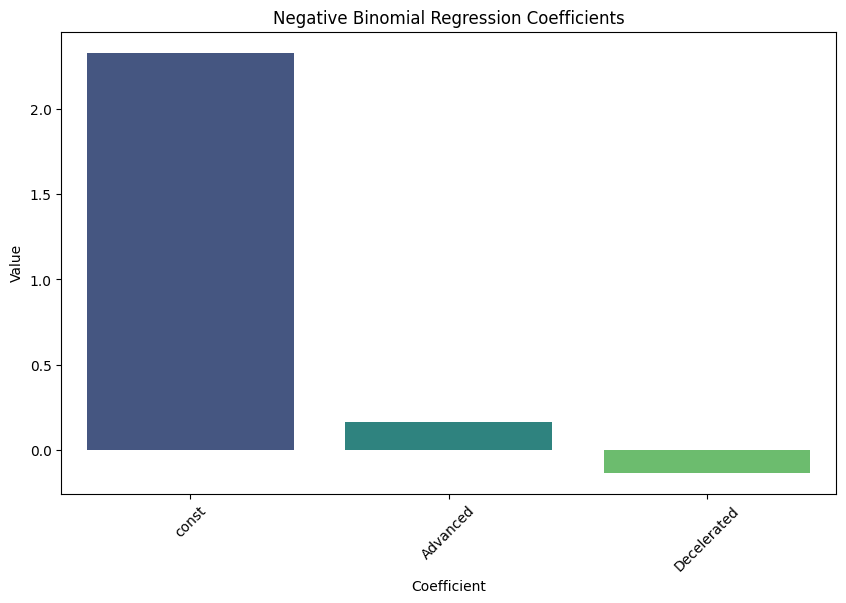

In [20]:
# Lets perform a negative binomial regression to see the correlation between the heart age gap 
# and the outcome (Number of hospitalizations in the next 365 days)
'''
Because the data has 3 categories, we will use dummy variables to represent the heart age categories.

'''

# Perform the negative binomial regression
X = hospitalization_analysis_1[[ 'Advanced', 'Decelerated']]
y = hospitalization_analysis_1['hospitalization_count']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Get the exponentiated coefficients (exp(coef))
exp_coef = np.exp(model.params)

# Display the model summary and exp(coef)
print(model.summary())
print("\nExponentiated Coefficients (exp(coef)):")
print(exp_coef)
    
# Lets visualize the results

# plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=model.params.index, y=model.params.values, palette='viridis')
plt.title('Negative Binomial Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()



Interpretation of the Results

    Normal (const):
        Coefficient: 2.3316
        This represents the log of the expected number of hospitalizations for the reference category (i.e., individuals with a Normal heart age category) when Advanced and Decelerated are both zero (i.e., normal heart age).
        Exponentiated coefficient: The expected count of hospitalizations for the Normal heart age category is approximately 10.29 hospitalizations over the next 365 days.

    Advanced:
        Coefficient: 0.1611
        The coefficient represents the log increase in the expected number of hospitalizations for patients with an Advanced heart age compared to those with a Normal heart age.

        Exponentiated coefficient: 1.175. This means individuals in the Advanced heart age category have approximately a 17.5% higher expected count of hospitalizations compared to those in the Normal heart age category, controlling for other factors.

        P-value: 0.000 

    Decelerated:
        Coefficient: -0.1345
        The coefficient represents the log decrease in the expected number of hospitalizations for patients with a Decelerated heart age compared to those with a Normal heart age.

        Exponentiated coefficient: 0.874. This means individuals in the Decelerated heart age category have approximately 12.6% fewer expected hospitalizations compared to those with a Normal heart age.
        
        P-value: 0.000 (highly significant)

In [ ]:
   Conclusions:
   
   Overdispersion:
        The analysis revealed that the hospitalization data is overdispersed, meaning there is more variability than would be expected in a standard Poisson model. Hence, a negative binomial regression was more appropriate for modeling hospitalizations.

   
    Modeling Hospitalizations:
        A Negative Binomial Regression model was used to evaluate the impact of heart age categories on hospitalization count.
        The model found that:
            Patients with Advanced Heart Age had a 17.5% higher expected count of hospitalizations compared to those with normal heart age.
            Patients with Decelerated Heart Age had a 12.6% lower expected count of hospitalizations compared to those with normal heart age.

    
    Significance:
        Both the Advanced and Decelerated heart age categories were statistically significant predictors of hospitalization frequency (P-value < 0.001).

Conclusions:

    The heart age is a significant predictor of the number of hospitalizations in the next year, with an older heart age associated with increased hospitalizations and a younger heart age associated with fewer hospitalizations.
    This analysis suggests that heart age could be used as an indicator to predict patient outcomes and may guide more personalized care strategies

In [117]:
# Save  the results as csv to use in the stratified analysis

path = 'C:/Users/Vero Ramirez/Desktop/CODE/'
hospitalization_analysis_1.to_csv(path + 'hospitalization_stratified.csv')